# <center>Homework 5</center>
### <center>_Tanner S Eastmond_</center>

## Working with the MNIST Data

Anyone who knows anything about machine learning or deep learning knows about the MNIST data, which is roughly the equivalent of 'Hello, World!' for machine learning. Today we will dive in and work with these data a little bit to see what we can learn.

In [15]:
# Import the packages we need.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline
np.random.seed(42)

Let's first read in the data using sci-kit learn's built in function to grab the MNIST data.

In [2]:
# Read in the data.
mnist = fetch_mldata("MNIST original")

# Define the x and y data.
X = mnist.data / 255.0
y = mnist.target

### PCA

Let's spend some time dealing with the dimensionality of the data. We are going to first use Principal Component Analysis (PCA) to reduct the dimensionality of the data.

Importantly, we need to decide how many components to use for the PCA. In order to decide this, we are going to make a bunch of components and plot the cumulative explained variance ratio.

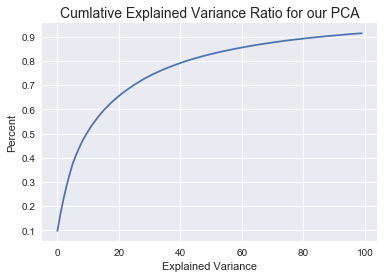

In [3]:
# First we will define the number of components. I am going to use 100 as a starting point.
pca = PCA(n_components=100)

# Now we fit the transformation to our data.
X_pca = pca.fit_transform(X)

# Lastly we get the cumulative ratio and plot it to find an 'elbow'.
cum_sum = np.cumsum(pca.explained_variance_ratio_)
plt.title('Cumlative Explained Variance Ratio for our PCA', fontsize=14)
plt.xlabel('Explained Variance')
plt.ylabel('Percent')
plt.plot(range(len(cum_sum)), cum_sum)

It looks like the elbow is around 20, so we will use 20 components for our PCA, then we will plot our first two components to examine them together.

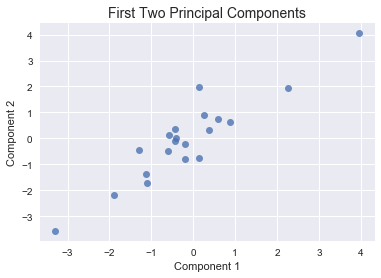

In [4]:
# First we will define the number of components. I am going to use 100 as a starting point.
pca = PCA(n_components=20)

# Now we fit the transformation to our data.
X_pca = pca.fit_transform(X)

# Plot the components.
plt.title('First Two Principal Components', fontsize=14)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
sns.regplot(X_pca[0], X_pca[1], fit_reg=False)

It is pretty clear that component 1 has higher variance that component 2, and they are clearly positively correlated. 

PCA is pretty interesting, it essentially uses a singular value decomposition to reduce the dimensionality of our data. Thus we would most often see this in a setting where our data had very high dimension. We do lose a little bit of information, though, which we will illustrate below.

To show that we are preserving most of the information, let's compress a couple of images and uncompress them to see what happens. We will do one of each letter.

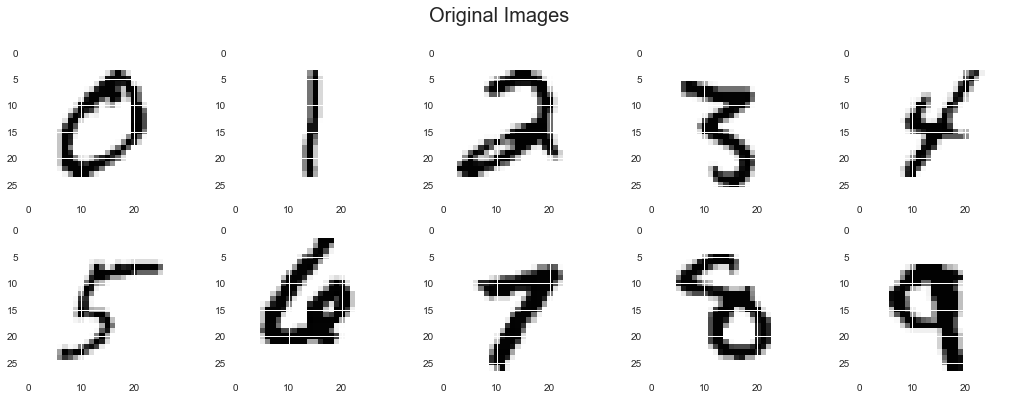

In [5]:
# Get one of each type of image.
ind = [0, 10002, 15000, 20002, 30001, 35001, 40000, 45001, 50000, 55000]

# Initialize the figure.
fig, axes = plt.subplots(2, 5, figsize=(18,6))

# Title the figure.
fig.suptitle('Original Images', fontsize=20)

# Set each of the images.
pix = []
for x, ax in enumerate(axes.flatten()):
    pix.append(X[ind[x]].reshape((28, 28)))
    ax.imshow(pix[x], cmap='Greys')

Those are pretty nice, now let's compress then uncompress the images to examine them.

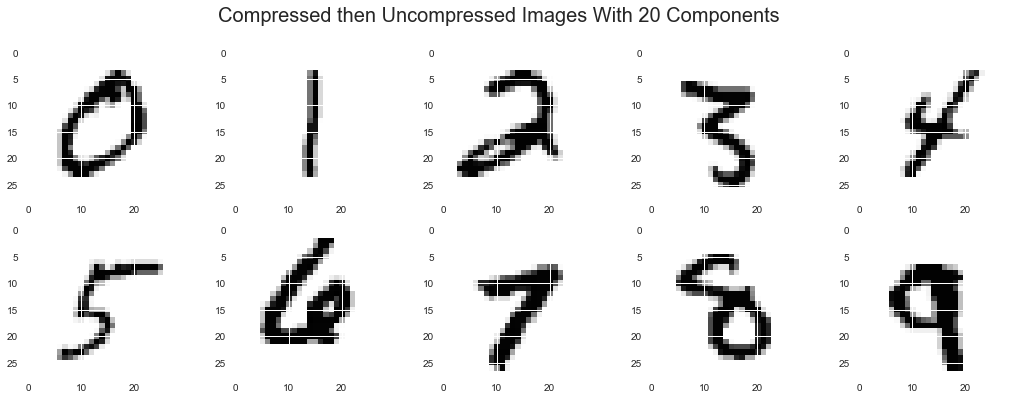

In [6]:
# Let's use 20 components, as specified above.
pca = PCA(n_components=20)
hold = pix

# Transform each image then restore it.
for x in range(len(pix)):
    pix[x] = pca.fit_transform(pix[x])
    pix[x] = pca.inverse_transform(pix[x])
    
# Initialize the figure.
fig, axes = plt.subplots(2, 5, figsize=(18,6))

# Title the figure.
fig.suptitle('Compressed then Uncompressed Images With 20 Components', fontsize=20)

# Set each of the images.
for x, ax in enumerate(axes.flatten()):
    ax.imshow(pix[x], cmap='Greys')

Great! We actually did quite well. It appears that we did not lose much information. For illustrative purposes, we will show the same figures using 5 components below.

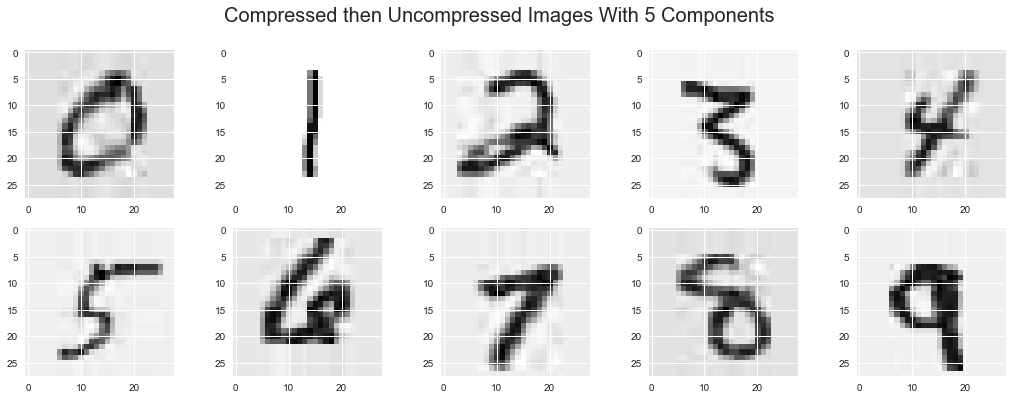

In [7]:
# Now let's use 5 components, 20 does not show a clear difference in the pictures.
pca = PCA(n_components=5)
pix = hold

# Transform each image then restore it.
for x in range(len(pix)):
    pix[x] = pca.fit_transform(pix[x])
    pix[x] = pca.inverse_transform(pix[x])
    
# Initialize the figure.
fig, axes = plt.subplots(2, 5, figsize=(18,6))

# Title the figure.
fig.suptitle('Compressed then Uncompressed Images With 5 Components', fontsize=20)

# Set each of the images.
for x, ax in enumerate(axes.flatten()):
    ax.imshow(pix[x], cmap='Greys')

Quite a bit fuzzier! The 1 stays quite well, which is pretty interesting. We have had some fun with PCA, let's move on to TSNE now.

### TSNE

TSNE is another dimensionality reduction technique, but is used primarily for visualization. Let's jump right in and see what we end up with in comparison to PCA.

In [8]:
# We need to reduce the dimensionality first.
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

# We also need a random sample from our data, but first let's shuffle the data.
rows = np.arange(70000)
np.random.shuffle(rows)
sample = 2500

# Now we need to fit the algorithm.
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:sample],:])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.003s...
[t-SNE] Computed neighbors for 2500 samples in 0.926s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 2.049683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.427216
[t-SNE] Error after 1000 iterations: 1.161153


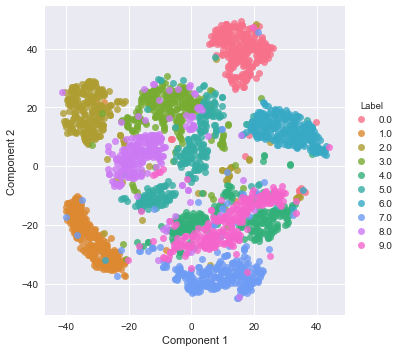

In [9]:
# Assign the data to a dataframe.
df = pd.DataFrame(tsne_results, columns=['Component 1', 'Component 2'])
df['Label'] = y[rows[:sample]]

# Plot the data.
sns.lmplot(x='Component 1', y='Component 2', data=df, hue='Label', fit_reg=False)

Quite a bit different than PCA! We get quite a bit of mixing in the middle, but overall there are some pretty clear clusters.

We also need to examine how sensitive this is to changes in perplexity, learning rate, and number of iterations below.

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.009s...
[t-SNE] Computed neighbors for 2500 samples in 0.473s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 1.075676
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.994698
[t-SNE] Error after 1000 iterations: 1.235121


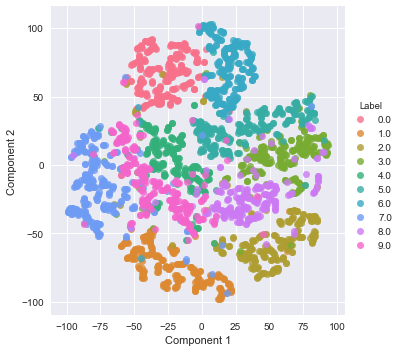

In [10]:
# Now let's fit the algorithm using different perplexity.
tsne1 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200)
tsne_results1 = tsne1.fit_transform(X_pca[rows[:sample],:])

# Assign the data to a dataframe.
df1 = pd.DataFrame(tsne_results1, columns=['Component 1', 'Component 2'])
df1['Label'] = y[rows[:sample]]

# Plot the data.
sns.lmplot(x='Component 1', y='Component 2', data=df1, hue='Label', fit_reg=False)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.005s...
[t-SNE] Computed neighbors for 2500 samples in 0.732s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 2.049683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.617226
[t-SNE] Error after 1000 iterations: 1.166322


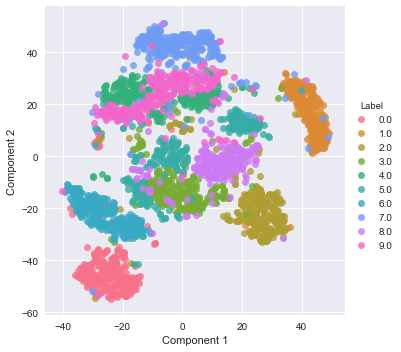

In [11]:
# Now let's fit the algorithm using different learning rate.
tsne2 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=500)
tsne_results2 = tsne2.fit_transform(X_pca[rows[:sample],:])

# Assign the data to a dataframe.
df2 = pd.DataFrame(tsne_results2, columns=['Component 1', 'Component 2'])
df2['Label'] = y[rows[:sample]]

# Plot the data.
sns.lmplot(x='Component 1', y='Component 2', data=df2, hue='Label', fit_reg=False)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.008s...
[t-SNE] Computed neighbors for 2500 samples in 0.693s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 2.049683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.429459
[t-SNE] Error after 500 iterations: 1.179400


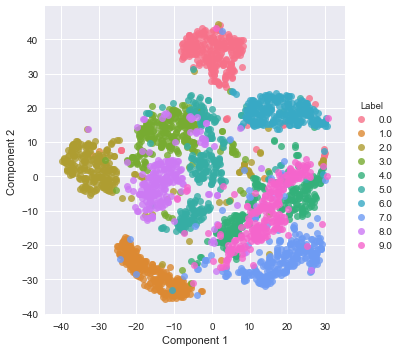

In [12]:
# Now let's fit the algorithm using different number of iterations.
tsne3 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500, learning_rate=200)
tsne_results3 = tsne3.fit_transform(X_pca[rows[:sample],:])

# Assign the data to a dataframe.
df3 = pd.DataFrame(tsne_results3, columns=['Component 1', 'Component 2'])
df3['Label'] = y[rows[:sample]]

# Plot the data.
sns.lmplot(x='Component 1', y='Component 2', data=df3, hue='Label', fit_reg=False)

Okay so it looks like TSNE is very sensitive to changes in perplexity, but at least with the changes we made, it was not as sensitive to changes in learning rate or number of iterations.

### K-Means Clustering

Looking at K-Means Clustering, we will naturally use $k=10$ since we have 10 different digits. Since each pixel is a fairly comparable feature, I decided not to scale my data in this case.

In [27]:
# Run the model with 10 clusters.
kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans.fit(X[rows[:5000]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=50, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
# Predict the results.
clusters = kmeans.predict(X)

In [29]:
# Evaluate how well we did.
metrics.adjusted_rand_score(y, clusters)

0.38031448156411846

We used an adjusted random score to evaluate how our clustering did, which gives us a nice score between 0 and 1 evaluating our label assignment. This scoring measures similarity between label assignment and ignores permutation. We did not do very well, getting only about 38% of the labels correct based on our clusters.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.003s...
[t-SNE] Computed neighbors for 2500 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 33.953655
[t-SNE] Error after 500 iterations: 0.025974


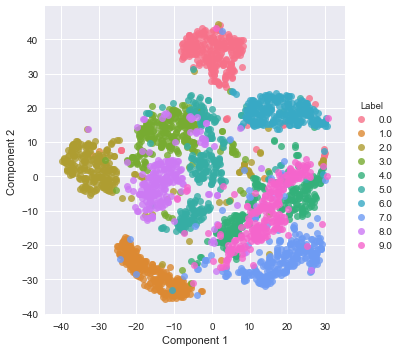

In [46]:
# Use TSNE to visualize our clusters.
tsne4 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500, learning_rate=200)
tsne_results4 = tsne4.fit_transform(clusters.reshape(-1,1)[rows[:sample],:])

# Assign the data to a dataframe.
df4 = pd.DataFrame(tsne_results3, columns=['Component 1', 'Component 2'])
df4['Label'] = y[rows[:sample]]

# Plot the data.
sns.lmplot(x='Component 1', y='Component 2', data=df4, hue='Label', fit_reg=False)

That kept largely the same clusters we saw before, pretty amazing! We also need to consider how robust our clustering is, so we will train it on a few different subsets of our data then compare the predictions.

In [48]:
# Run the model with three different samples.
kmeans1 = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans1.fit(X[rows[5001:10000]])

kmeans2 = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans2.fit(X[rows[10001:15000]])

kmeans3 = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans3.fit(X[rows[15001:20000]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=50, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [51]:
# Make predictions on those models.
clusters1 = kmeans1.predict(X)
clusters2 = kmeans2.predict(X)
clusters3 = kmeans3.predict(X)

In [52]:
# Evaluate the differences between samples.
print(metrics.adjusted_rand_score(clusters, clusters1))
print(metrics.adjusted_rand_score(clusters, clusters2))
print(metrics.adjusted_rand_score(clusters, clusters3))
print(metrics.adjusted_rand_score(clusters1, clusters2))
print(metrics.adjusted_rand_score(clusters1, clusters3))
print(metrics.adjusted_rand_score(clusters2, clusters3))

0.670853259511
0.672494223451
0.721200479475
0.811085072459
0.677338971345
0.650176082467


Yikes, the model is not super robust to changes in the sample. We are only about 2/3 the same with our predictions based on which sample we used.

### Hierarchical Clustering

Lastly we will use hierarchical clustering to see what is going on in our MNIST data. First, we will plot the dendrogram.

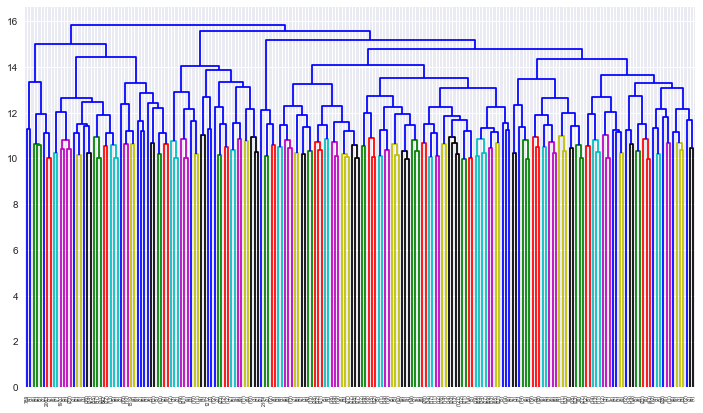

In [60]:
# Initialize and plot the dendrogram using a sample from our data.
Z = linkage(X[rows[:sample]], 'complete')
plt.figure(figsize=(12, 7))
_ = dendrogram(Z, p=200, truncate_mode='lastp')

We trucated the dendrogram because we end up with a lot of clusters really fast, but based solely on this it seems that 8-12 clusters would be reasonable. After that it starts to branch out super quickly.

The last thing we will do is plot the dendrogram with different linkage methods.

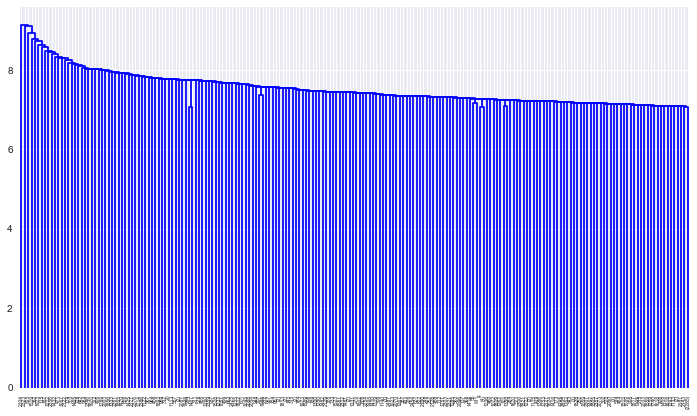

In [61]:
# Try single linkage method.
Z = linkage(X[rows[:sample]], 'single')
plt.figure(figsize=(12, 7))
_ = dendrogram(Z, p=200, truncate_mode='lastp')

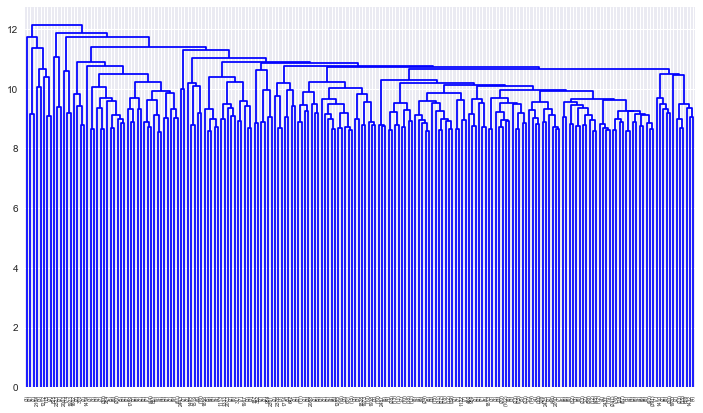

In [62]:
# Try average linkage method.
Z = linkage(X[rows[:sample]], 'average')
plt.figure(figsize=(12, 7))
_ = dendrogram(Z, p=200, truncate_mode='lastp')

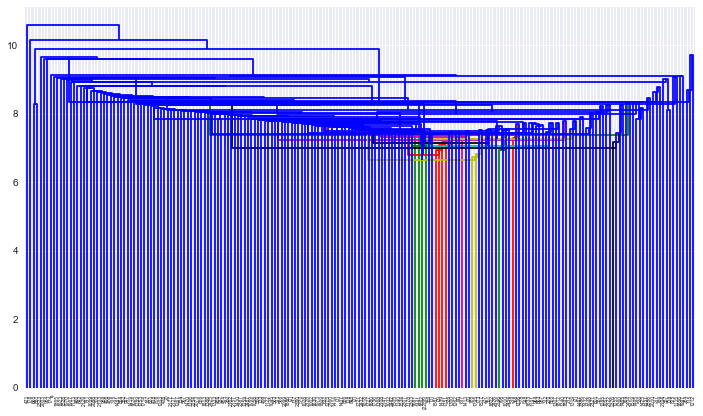

In [63]:
# Try centroid linkage method.
Z = linkage(X[rows[:sample]], 'centroid')
plt.figure(figsize=(12, 7))
_ = dendrogram(Z, p=200, truncate_mode='lastp')

Wow, okay the dendrogram changes drastically with different linkage methods, with the other methods being much harder to interpret than complete.

We have poked around the MNIST dataset using a number of different methods. This famous data has helped us a lot to think about and conceptualize these different techniques for handling and visualizing data.